<a href="https://colab.research.google.com/github/DzikriDhaniawan/deteksiUmurJanin/blob/main/JANINFIXPLIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**

In [ ]:
print("=" * 60)
print("CELL 1: Import Libraries dan Setup")
print("=" * 60)

import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import feature, transform
import random
from google.colab import files
import io
from PIL import Image
import math

print("✓ Semua library berhasil diimport")
print()

CELL 1: Import Libraries dan Setup
✓ Semua library berhasil diimport



CELL 2: Upload Gambar USG
Silakan upload gambar USG janin...


Saving janingas.PNG to janingas (1).PNG
✓ Gambar 'janingas (1).PNG' berhasil diupload
✓ Ukuran gambar: (306, 345, 4)



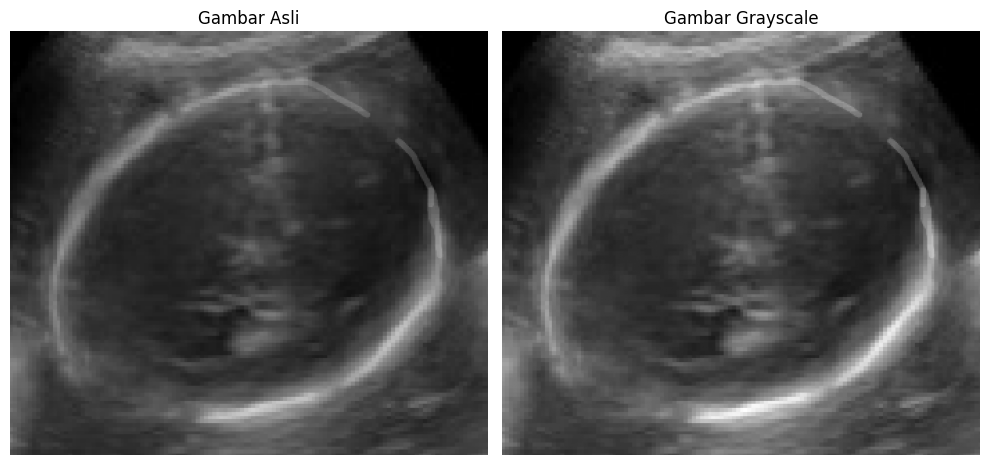

In [ ]:
print("=" * 60)
print("CELL 2: Upload Gambar USG")
print("=" * 60)

print("Silakan upload gambar USG janin...")
uploaded = files.upload()

image_name = list(uploaded.keys())[0]
img = Image.open(io.BytesIO(uploaded[image_name]))
img = np.array(img)

if len(img.shape) == 3:
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
else:
    img_gray = img.copy()

print(f"✓ Gambar '{image_name}' berhasil diupload")
print(f"✓ Ukuran gambar: {img.shape}")
print()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Gambar Asli')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap='gray')
plt.title('Gambar Grayscale')
plt.axis('off')
plt.tight_layout()
plt.show()

CELL 3: Preprocessing - Resize dan Filter
✓ Gambar diresize ke: (270, 268)
✓ Gaussian smoothing diterapkan dengan kernel (5, 5)



/tmp/ipython-input-2398876158.py:27: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(img_smooth.ravel(), 256, [0, 256])


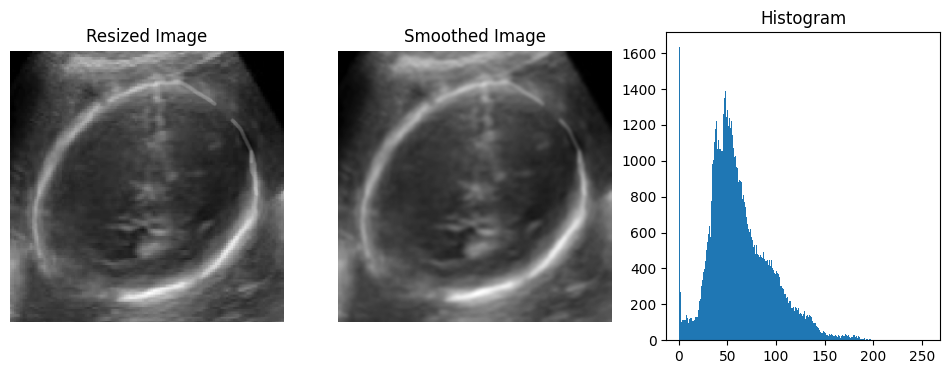

In [ ]:
print("=" * 60)
print("CELL 3: Preprocessing - Resize dan Filter")
print("=" * 60)

target_size = (270, 268)
img_resized = cv2.resize(img_gray, target_size)
print(f" Gambar diresize ke: {target_size}")

kernel_size = (5, 5)
img_smooth = cv2.GaussianBlur(img_resized, kernel_size, 1.4)
print(f" Gaussian smoothing diterapkan dengan kernel {kernel_size}")
print()

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_resized, cmap='gray')
plt.title('Resized Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(img_smooth, cmap='gray')
plt.title('Smoothed Image')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.hist(img_smooth.ravel(), 256, [0, 256])
plt.title('Histogram')
plt.show()

CELL 4: Edge Detection dengan Canny
✓ Canny edge detection diterapkan
  - Low threshold: 40
  - High threshold: 120
✓ Jumlah edge pixels: 1368



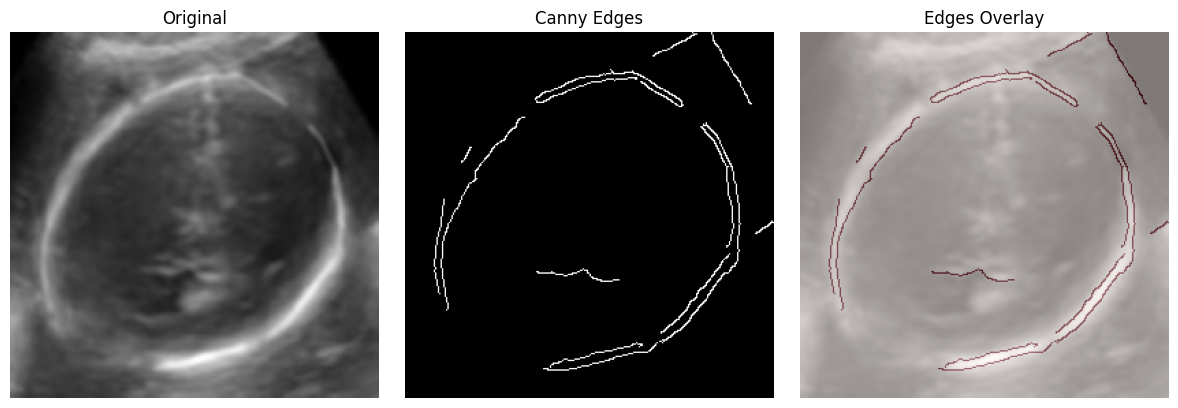

In [ ]:
print("=" * 60)
print("CELL 4: Edge Detection dengan Canny")
print("=" * 60)

low_threshold = 40
high_threshold = 120
edges = cv2.Canny(img_smooth, low_threshold, high_threshold)

print(f" Canny edge detection diterapkan")
print(f"  - Low threshold: {low_threshold}")
print(f"  - High threshold: {high_threshold}")
print(f"✓ Jumlah edge pixels: {np.sum(edges > 0)}")
print()

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_smooth, cmap='gray')
plt.title('Original')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edges')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(img_smooth, cmap='gray')
plt.imshow(edges, cmap='Reds', alpha=0.5)
plt.title('Edges Overlay')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
print("=" * 60)
print("CELL 5: Implementasi IRHT (Iterative Randomized Hough Transform)")
print("=" * 60)

class IRHT_EllipseDetector:
    def __init__(self, edge_image, num_iterations=200, num_scans=4,
                 min_size=30, max_size=200):
        self.edge_image = edge_image
        self.num_iterations = num_iterations
        self.num_scans = num_scans
        self.edge_points = np.column_stack(np.where(edge_image > 0))
        self.best_ellipse = None
        self.best_score = 0
        self.min_size = min_size
        self.max_size = max_size

        print(f" IRHT Detector diinisialisasi")
        print(f"  - Jumlah iterasi: {num_iterations}")
        print(f"  - Jumlah scanning: {num_scans}")
        print(f"  - Min size: {min_size} px, Max size: {max_size} px")
        print(f"  - Edge points terdeteksi: {len(self.edge_points)}")

    def fit_ellipse_from_points(self, points):
        """Fit ellipse dari 5 titik acak"""
        if len(points) < 5:
            return None

        try:
            idx = random.sample(range(len(points)), min(5, len(points)))
            pts = points[idx]

            x = pts[:, 1]
            y = pts[:, 0]

            D = np.column_stack([x**2, x*y, y**2, x, y, np.ones_like(x)])

            _, _, V = np.linalg.svd(D)
            coeffs = V[-1]

            return self.coeffs_to_ellipse_params(coeffs)
        except:
            return None

    def coeffs_to_ellipse_params(self, coeffs):
        """Convert koefisien ke parameter ellipse (x0, y0, a, b, theta)"""
        A, B, C, D, E, F = coeffs

        den = B**2 - 4*A*C
        if den >= 0:
            return None

        x0 = (2*C*D - B*E) / den
        y0 = (2*A*E - B*D) / den

        num = 2 * (A*E**2 + C*D**2 - B*D*E + den*F)
        den1 = den * (np.sqrt((A-C)**2 + B**2) - (A+C))
        den2 = den * (-np.sqrt((A-C)**2 + B**2) - (A+C))

        if den1 <= 0 or den2 <= 0:
            return None

        a = np.sqrt(num / den1)
        b = np.sqrt(num / den2)

        if max(a, b) < self.min_size or max(a, b) > self.max_size:
            return None
        if min(a, b) < self.min_size * 0.5:
            return None

        if B == 0:
            if A < C:
                theta = 0
            else:
                theta = np.pi / 2
        else:
            theta = np.arctan2(C - A - np.sqrt((A-C)**2 + B**2), B)

        return {
            'x0': x0, 'y0': y0,
            'a': max(a, b), 'b': min(a, b),
            'theta': theta
        }

    def score_ellipse(self, ellipse_params):
        """Hitung score ellipse berdasarkan edge points"""
        if ellipse_params is None:
            return 0

        x0, y0 = ellipse_params['x0'], ellipse_params['y0']
        a, b = ellipse_params['a'], ellipse_params['b']
        theta = ellipse_params['theta']

        num_samples = 200
        t = np.linspace(0, 2*np.pi, num_samples)
        ellipse_x = x0 + a * np.cos(t) * np.cos(theta) - b * np.sin(t) * np.sin(theta)
        ellipse_y = y0 + a * np.cos(t) * np.sin(theta) + b * np.sin(t) * np.cos(theta)

        score = 0
        threshold = 8

        for ex, ey in zip(ellipse_x, ellipse_y):
            if 0 <= ey < self.edge_image.shape[0] and 0 <= ex < self.edge_image.shape[1]:
                y_min = max(0, int(ey) - threshold)
                y_max = min(self.edge_image.shape[0], int(ey) + threshold)
                x_min = max(0, int(ex) - threshold)
                x_max = min(self.edge_image.shape[1], int(ex) + threshold)

                if np.any(self.edge_image[y_min:y_max, x_min:x_max] > 0):
                    score += 1

        return score / len(t)

    def detect(self):
        """Deteksi ellipse dengan IRHT"""
        print("\n Memulai proses deteksi IRHT...")

        for scan in range(self.num_scans):
            print(f"\n Scanning {scan + 1}/{self.num_scans}")

            for iteration in range(self.num_iterations):
                ellipse_params = self.fit_ellipse_from_points(self.edge_points)

                if ellipse_params is not None:
                    score = self.score_ellipse(ellipse_params)

                    if score > self.best_score:
                        self.best_score = score
                        self.best_ellipse = ellipse_params
                        print(f"   Iterasi {iteration + 1}: Score baru = {score:.4f}")

            print(f"  Best score scan {scan + 1}: {self.best_score:.4f}")

        return self.best_ellipse

detector = IRHT_EllipseDetector(
    edges,
    num_iterations=200,
    num_scans=6,
    min_size=40,
    max_size=180
)
best_ellipse = detector.detect()

print("\n" + "=" * 60)
print("HASIL DETEKSI ELLIPSE:")
print("=" * 60)
if best_ellipse:
    print(f"✓ Ellipse terdeteksi!")
    print(f"  - Center (x0, y0): ({best_ellipse['x0']:.2f}, {best_ellipse['y0']:.2f})")
    print(f"  - Semi-major axis (a): {best_ellipse['a']:.2f} pixels")
    print(f"  - Semi-minor axis (b): {best_ellipse['b']:.2f} pixels")
    print(f"  - Rotation angle: {np.degrees(best_ellipse['theta']):.2f}°")
    print(f"  - Best score: {detector.best_score:.4f}")
else:
    print("✗ Ellipse tidak terdeteksi")
print()

CELL 5: Implementasi IRHT (Iterative Randomized Hough Transform)
 IRHT Detector diinisialisasi
  - Jumlah iterasi: 200
  - Jumlah scanning: 6
  - Min size: 40 px, Max size: 180 px
  - Edge points terdeteksi: 1368

 Memulai proses deteksi IRHT...

 Scanning 1/6
   Iterasi 1: Score baru = 0.5950
   Iterasi 2: Score baru = 0.6400
   Iterasi 5: Score baru = 0.7200
   Iterasi 10: Score baru = 0.8400
   Iterasi 37: Score baru = 0.8850
  Best score scan 1: 0.8850

 Scanning 2/6
  Best score scan 2: 0.8850

 Scanning 3/6
  Best score scan 3: 0.8850

 Scanning 4/6
  Best score scan 4: 0.8850

 Scanning 5/6
  Best score scan 5: 0.8850

 Scanning 6/6
  Best score scan 6: 0.8850

HASIL DETEKSI ELLIPSE:
✓ Ellipse terdeteksi!
  - Center (x0, y0): (133.69, 140.29)
  - Semi-major axis (a): 116.14 pixels
  - Semi-minor axis (b): 95.39 pixels
  - Rotation angle: -41.18°
  - Best score: 0.8850



CELL 6: Visualisasi Hasil Deteksi Ellipse


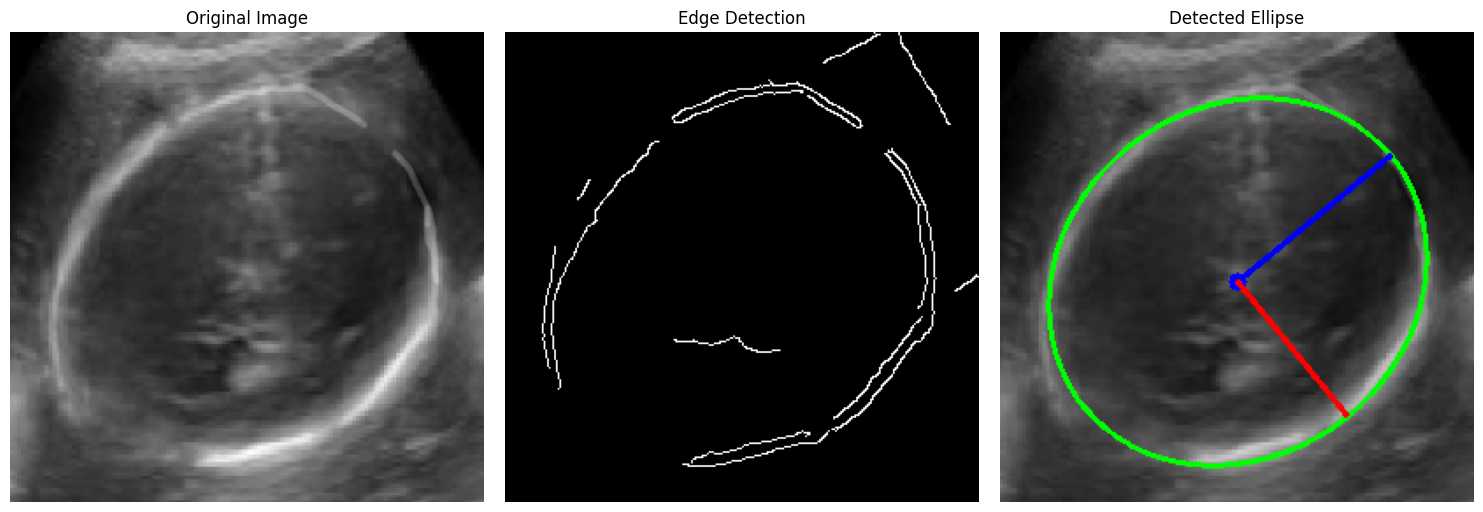

✓ Visualisasi selesai



In [ ]:
print("=" * 60)
print("CELL 6: Visualisasi Hasil Deteksi Ellipse")
print("=" * 60)

def draw_ellipse(image, ellipse_params, color=(0, 255, 0), thickness=2):
    """Gambar ellipse pada image"""
    if ellipse_params is None:
        return image

    img_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR) if len(image.shape) == 2 else image.copy()

    center = (int(ellipse_params['x0']), int(ellipse_params['y0']))
    axes = (int(ellipse_params['a']), int(ellipse_params['b']))
    angle = np.degrees(ellipse_params['theta'])

    cv2.ellipse(img_color, center, axes, angle, 0, 360, color, thickness)

    cv2.circle(img_color, center, 5, (255, 0, 0), -1)

    major_x1 = int(center[0] + axes[0] * np.cos(ellipse_params['theta']))
    major_y1 = int(center[1] + axes[0] * np.sin(ellipse_params['theta']))
    cv2.line(img_color, center, (major_x1, major_y1), (255, 0, 0), 2)

    minor_x1 = int(center[0] - axes[1] * np.sin(ellipse_params['theta']))
    minor_y1 = int(center[1] + axes[1] * np.cos(ellipse_params['theta']))
    cv2.line(img_color, center, (minor_x1, minor_y1), (0, 0, 255), 2)

    return img_color

# Visualisasi
img_with_ellipse = draw_ellipse(img_resized, best_ellipse)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_resized, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title('Edge Detection')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(img_with_ellipse, cv2.COLOR_BGR2RGB))
plt.title('Detected Ellipse')
plt.axis('off')
plt.tight_layout()
plt.show()

print("✓ Visualisasi selesai")
print()

In [ ]:
print("=" * 60)
print("CELL 7: Perhitungan BPD dan HC")
print("=" * 60)

def calculate_measurements(ellipse_params, pixel_to_mm_ratio=0.25):
    """
    Hitung BPD dan HC dari parameter ellipse
    BPD = 2 * b (semiminor axis)
    HC = 3.14 * (BPD + OFD) / 2, dimana OFD ≈ 2 * a (semimajor axis)
    """
    if ellipse_params is None:
        return None, None

    BPD_pixels = 2 * ellipse_params['b']

    OFD_pixels = 2 * ellipse_params['a']

    a = ellipse_params['a']
    b = ellipse_params['b']
    HC_pixels = np.pi * (3*(a + b) - np.sqrt((3*a + b)*(a + 3*b)))

    BPD_mm = BPD_pixels * pixel_to_mm_ratio
    HC_mm = HC_pixels * pixel_to_mm_ratio

    return BPD_mm, HC_mm

BPD, HC = calculate_measurements(best_ellipse, pixel_to_mm_ratio=0.25)

if BPD and HC:
    print(f" HASIL PENGUKURAN:")
    print(f"  - BPD (Biparietal Diameter): {BPD:.2f} mm")
    print(f"  - HC (Head Circumference): {HC:.2f} mm")
else:
    print("✗ Tidak dapat menghitung BPD dan HC")
print()

CELL 7: Perhitungan BPD dan HC
 HASIL PENGUKURAN:
  - BPD (Biparietal Diameter): 47.70 mm
  - HC (Head Circumference): 166.54 mm



In [ ]:
print("=" * 60)
print("CELL 8: Prediksi Usia Janin (Gestational Age)")
print("=" * 60)

def predict_gestational_age(BPD_mm, HC_mm):
    """
    Prediksi usia gestasi berdasarkan BPD dan HC
    Menggunakan tabel referensi umum
    """
    if BPD_mm is None or HC_mm is None:
        return None

    # Tabel referensi BPD vs Gestational Age (dalam minggu)
    # Format: (BPD_min, BPD_max, gestational_age)
    bpd_reference = [
        (20, 25, 13), (25, 30, 14), (30, 35, 15), (35, 38, 16),
        (38, 42, 17), (42, 45, 18), (45, 48, 19), (48, 51, 20),
        (51, 54, 21), (54, 57, 22), (57, 60, 23), (60, 63, 24),
        (63, 66, 25), (66, 69, 26), (69, 72, 27), (72, 75, 28),
        (75, 78, 29), (78, 81, 30), (81, 84, 31), (84, 87, 32),
        (87, 90, 33), (90, 93, 34), (93, 96, 35), (96, 99, 36),
        (99, 102, 37), (102, 105, 38), (105, 110, 39), (110, 115, 40)
    ]

    # Prediksi dari BPD
    age_from_bpd = None
    for bpd_min, bpd_max, age in bpd_reference:
        if bpd_min <= BPD_mm < bpd_max:
            age_from_bpd = age
            break

    if age_from_bpd is None:
        if BPD_mm < 20:
            age_from_bpd = 12
        elif BPD_mm >= 115:
            age_from_bpd = 41
        else:
            age_from_bpd = 13 + (BPD_mm - 20) / 2.5

    # Prediksi dari HC (simplified)
    age_from_hc = 13 + (HC_mm - 100) / 10

    # Rata-rata prediksi
    gestational_age = (age_from_bpd + age_from_hc) / 2

    return gestational_age

# Prediksi usia
if BPD and HC:
    gestational_age = predict_gestational_age(BPD, HC)

    print(f" PREDIKSI USIA JANIN:")
    print(f"  - Usia Gestasi: {gestational_age:.1f} minggu")
    print(f"  - Atau sekitar: {gestational_age/4:.1f} bulan")

    if gestational_age <= 13:
        trimester = "Trimester 1"
    elif gestational_age <= 26:
        trimester = "Trimester 2"
    else:
        trimester = "Trimester 3"

    print(f"  - Trimester: {trimester}")
else:
    print("✗ Tidak dapat memprediksi usia janin")
print()

CELL 8: Prediksi Usia Janin (Gestational Age)
 PREDIKSI USIA JANIN:
  - Usia Gestasi: 19.3 minggu
  - Atau sekitar: 4.8 bulan
  - Trimester: Trimester 2



CELL 9: LAPORAN LENGKAP


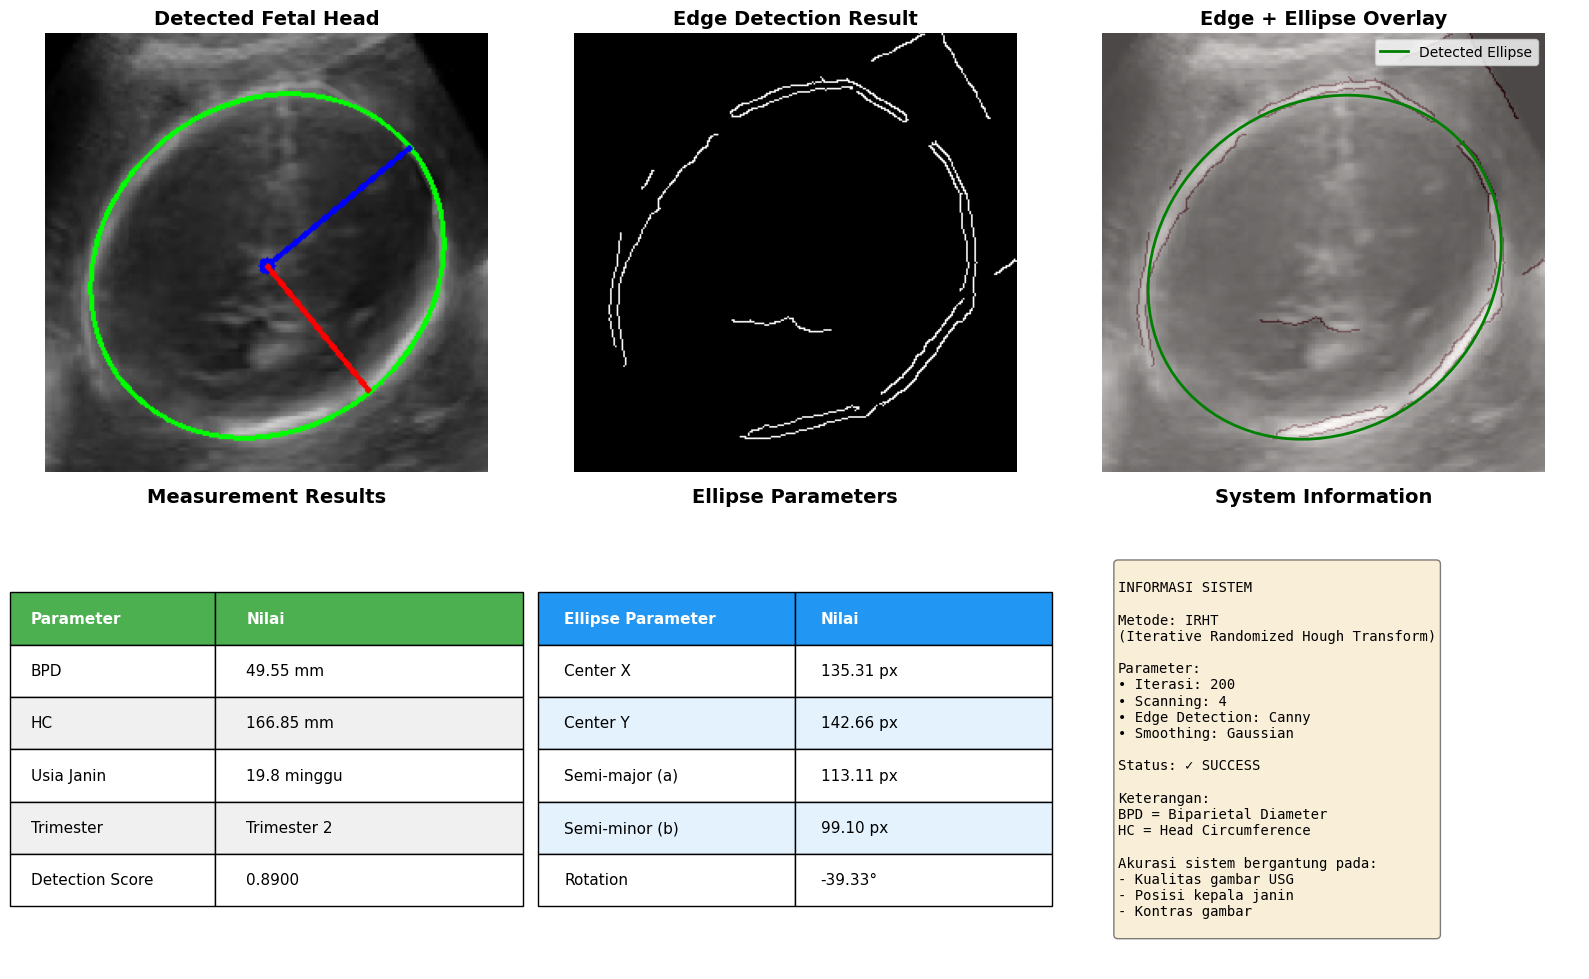


RINGKASAN HASIL
✓ BPD: 49.55 mm
✓ HC: 166.85 mm
✓ Usia Janin: 19.8 minggu (Trimester 2)
✓ Detection Score: 0.8900

✓ Program selesai dijalankan


In [ ]:
print("=" * 60)
print("CELL 9: LAPORAN LENGKAP")
print("=" * 60)

fig = plt.figure(figsize=(16, 10))

ax1 = plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(img_with_ellipse, cv2.COLOR_BGR2RGB))
plt.title('Detected Fetal Head', fontsize=14, fontweight='bold')
plt.axis('off')

ax2 = plt.subplot(2, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title('Edge Detection Result', fontsize=14, fontweight='bold')
plt.axis('off')

ax3 = plt.subplot(2, 3, 3)
plt.imshow(img_resized, cmap='gray')
plt.imshow(edges, cmap='Reds', alpha=0.3)
if best_ellipse:
    t = np.linspace(0, 2*np.pi, 100)
    x = best_ellipse['x0'] + best_ellipse['a'] * np.cos(t) * np.cos(best_ellipse['theta']) - best_ellipse['b'] * np.sin(t) * np.sin(best_ellipse['theta'])
    y = best_ellipse['y0'] + best_ellipse['a'] * np.cos(t) * np.sin(best_ellipse['theta']) + best_ellipse['b'] * np.sin(t) * np.cos(best_ellipse['theta'])
    plt.plot(x, y, 'g-', linewidth=2, label='Detected Ellipse')
    plt.legend()
plt.title('Edge + Ellipse Overlay', fontsize=14, fontweight='bold')
plt.axis('off')

ax4 = plt.subplot(2, 3, 4)
ax4.axis('off')
if BPD and HC and gestational_age:
    table_data = [
        ['Parameter', 'Nilai'],
        ['BPD', f'{BPD:.2f} mm'],
        ['HC', f'{HC:.2f} mm'],
        ['Usia Janin', f'{gestational_age:.1f} minggu'],
        ['Trimester', trimester],
        ['Detection Score', f'{detector.best_score:.4f}']
    ]
    table = ax4.table(cellText=table_data, cellLoc='left', loc='center',
                      colWidths=[0.4, 0.6])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.5)

    for i in range(2):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')

    for i in range(1, len(table_data)):
        for j in range(2):
            table[(i, j)].set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')

    plt.title('Measurement Results', fontsize=14, fontweight='bold', pad=20)

ax5 = plt.subplot(2, 3, 5)
ax5.axis('off')
if best_ellipse:
    param_data = [
        ['Ellipse Parameter', 'Nilai'],
        ['Center X', f'{best_ellipse["x0"]:.2f} px'],
        ['Center Y', f'{best_ellipse["y0"]:.2f} px'],
        ['Semi-major (a)', f'{best_ellipse["a"]:.2f} px'],
        ['Semi-minor (b)', f'{best_ellipse["b"]:.2f} px'],
        ['Rotation', f'{np.degrees(best_ellipse["theta"]):.2f}°']
    ]
    param_table = ax5.table(cellText=param_data, cellLoc='left', loc='center',
                            colWidths=[0.5, 0.5])
    param_table.auto_set_font_size(False)
    param_table.set_fontsize(11)
    param_table.scale(1, 2.5)

    for i in range(2):
        param_table[(0, i)].set_facecolor('#2196F3')
        param_table[(0, i)].set_text_props(weight='bold', color='white')

    for i in range(1, len(param_data)):
        for j in range(2):
            param_table[(i, j)].set_facecolor('#e3f2fd' if i % 2 == 0 else 'white')

    plt.title('Ellipse Parameters', fontsize=14, fontweight='bold', pad=20)

# Info text
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
info_text = f"""
INFORMASI SISTEM

Metode: IRHT
(Iterative Randomized Hough Transform)

Parameter:
• Iterasi: 200
• Scanning: 4
• Edge Detection: Canny
• Smoothing: Gaussian

Status: {' SUCCESS' if best_ellipse else '✗ FAILED'}

Keterangan:
BPD = Biparietal Diameter
HC = Head Circumference

Akurasi sistem bergantung pada:
- Kualitas gambar USG
- Posisi kepala janin
- Kontras gambar
"""
ax6.text(0.1, 0.5, info_text, fontsize=10, verticalalignment='center',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.title('System Information', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("RINGKASAN HASIL")
print("=" * 60)
if BPD and HC and gestational_age:
    print(f" BPD: {BPD:.2f} mm")
    print(f" HC: {HC:.2f} mm")
    print(f" Usia Janin: {gestational_age:.1f} minggu ({trimester})")
    print(f" Detection Score: {detector.best_score:.4f}")
else:
    print(" Deteksi gagal atau tidak lengkap")
print("=" * 60)
print("\n Program selesai dijalankan")